In [1]:
import os
import sys
import numpy as np
import sympy as sp

from pycalphad import Database, Model, calculate, variables as v
from fparser import *
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize, curve_fit

from matplotlib.lines import Line2D
from matplotlib.text import Text
from matplotlib.legend_handler import HandlerLine2D

## Loading TDB file

In [2]:
db_filename = 'tdb_files/Au.TDB'
phases = ['LIQUID','FCC_A1']

In [3]:
db = Database(db_filename)
available_phases = list(db.phases)
available_phases

['FCC_A1', 'LIQUID']

In [4]:
constituents = list(set([i for c in db.phases['LIQUID'].constituents for i in c])) # Elements 
constituents

[Species('AU', 'AU1')]

## Parsing TDB file Free Energy

In [5]:
for phase in phases:
    print(f'  [F_{phase}]')
    print('    type = DerivativeParsedMaterial')

    
    constituents = list(set([i for c in db.phases[phase].constituents for i in c])) # Elements 
    # constituents = ['AU', 'VA']
    
    # create thermodynamic model
    m = Model(db, constituents, phase)
    
    # export fparser expression
    # function_unparsed = m.ast
    # function_unparsed =  m.ast.subs({'T':'temp', 'LIQUID0AU':'c1',  'FCC_A10AU':'c2', 'FCC_A11VA':0})
    function_unparsed =  m.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})
    
    print(f"    function = '{fparser(function_unparsed)}'" )
    
    # print(variables
    print("    args = '%s'" % " ".join([v.name for v in function_unparsed.free_symbols]))
    print('  []')

# m.ast    

  [F_LIQUID]
    type = DerivativeParsedMaterial
    function = '24.9435*temp*log(1 - exp(-126.68742/temp)) - 8.3145*temp*log(1 + exp(-0.120271814300319*(19700.0 - 14.917*temp)/temp)) - 0.00067*temp^2.0 - 326.386169615'
    args = 'temp'
  []
  [F_FCC_A1]
    type = DerivativeParsedMaterial
    function = '24.9435*temp*log(1 - exp(-126.68742/temp)) + 1.0*if(temp < 1337.33,-0.001281018525*temp^2.0 - 4.02278360455656e-7*temp^3.0,1.55127e+36*temp^(-11.0) - 2.27748e+18*temp^(-5.0) - 2.0566206*temp*log(temp) + 9.807219*temp + 3898.778) - 6103.656619615'
    args = 'temp'
  []


## Plotting Free Energy From TDB expression

In [6]:
m_FCC = Model(db, ['AU', 'VA'], 'FCC_A1')
m_LIQ = Model(db, ['AU', 'VA'], 'LIQUID')

FCC_G = m_FCC.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})
LIQ_G = m_LIQ.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})

temperature_subs_FCC = sp.lambdify('temp', FCC_G, modules="numpy")
temperature_subs_LIQ = sp.lambdify('temp', LIQ_G, modules="numpy")

temp_FCC_TDB = np.linspace(300, 3000, 100)
temp_LIQ_TDB = np.linspace(300, 3000, 100)
F_FCC_TDB = temperature_subs_FCC(temp_FCC_TDB)
F_LIQ_TDB = temperature_subs_LIQ(temp_LIQ_TDB)

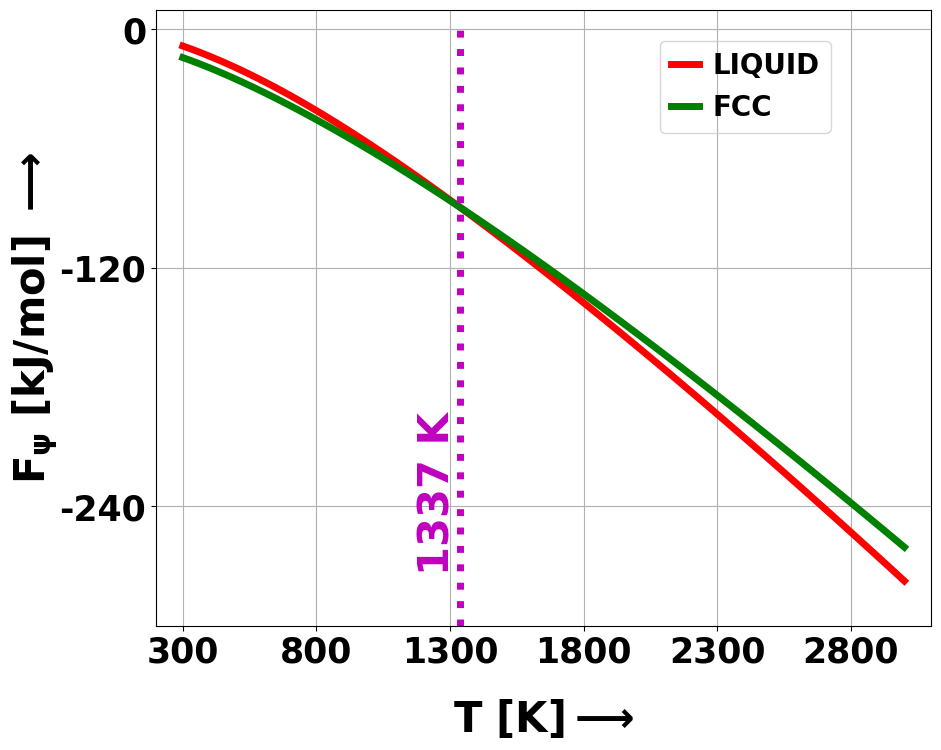

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=[10, 8], frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
                        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

ax1.plot(temp_LIQ_TDB, F_LIQ_TDB, c='r', lw=5, label='LIQUID')
ax1.plot(temp_FCC_TDB, F_FCC_TDB, c='g', lw=5, label='FCC')
ax1.grid(True)
ax1.set_ylim(-300_000, 10_000)
ax1.set_xlim(200, 3100)
ax1.set_xticks([300, 800, 1300, 1800, 2300, 2800], labels=[300, 800, 1300, 1800, 2300, 2800], size=25, weight='bold', color='k', rotation=0)
ax1.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=25, color='k', weight='bold')
ax1.set_ylabel(r"F$\mathbf{_\psi}$ [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=30, color='k')
ax1.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=20, size=30, color='k')
# ax1.set_title("Expression from  TDB", fontsize=25, weight='bold')
legend1 = ax1.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=1.0,   frameon=True).get_frame().set_facecolor('none')
ax1.vlines(x=1337, ymax=0, ymin=-300_000, linestyle=":", color='m', lw=5)
ax1.text(x=1175 ,y=-270_000 , s='1337 K', rotation=90, fontsize=30, weight='bold', color='m')

# plt.savefig('../../2_Post_Processing/figures/TDB_free_energy.png',bbox_inches='tight', dpi=800)
plt.show()

## Plotting Free Energy from Approximation using Polynomial Fitting

In [8]:
def Au_LIQ(temp):
    factor_f1, a1, b1, c1, d1, e1, f1, g_1, h_1, x1 = 10.412, 1337, 24474, 16.2, 24.5, 0.00214, 0.04512, 0.000019, -17.4, 2662
    return factor_f1*(a1-b1-c1*(temp-x1)+d1*(temp-x1)*np.log(e1*temp)+f1*(temp-x1)**2+g_1*(temp-x1)**3+h_1/temp)

def Au_FCC(temp):
    factor_f2, a2, b2, c2, d2, e2, f2, g_2, h_2, x2 = 9.03, 300, 515, -46.2, -13.5, 0.1985, -0.001, 0.00002, -0.001, 121
    return factor_f2*(a2-b2-c2*(temp-x2)+d2*(temp-x2)*np.log(e2*temp)+f2*(temp-x2)**2+g_2*(temp-x2)**3+h_2/temp)

temp_FCC_FIT = np.linspace(300, 1360, 100)
temp_LIQ_FIT = np.linspace(1320, 3000, 100)

F_LIQ_FIT = Au_LIQ(temp_LIQ_FIT)
F_FCC_FIT = Au_FCC(temp_FCC_FIT)
int_pts = np.argwhere(np.diff(np.sign(F_LIQ_FIT - F_FCC_FIT))).flatten()

Au_LIQ_min = minimize(Au_LIQ, x0=[2000], method= 'Powell', bounds=[(1337, 3000)])
Au_FCC_min = minimize(Au_FCC, x0=[1000], method= 'Powell', bounds=[(300, 1337)])

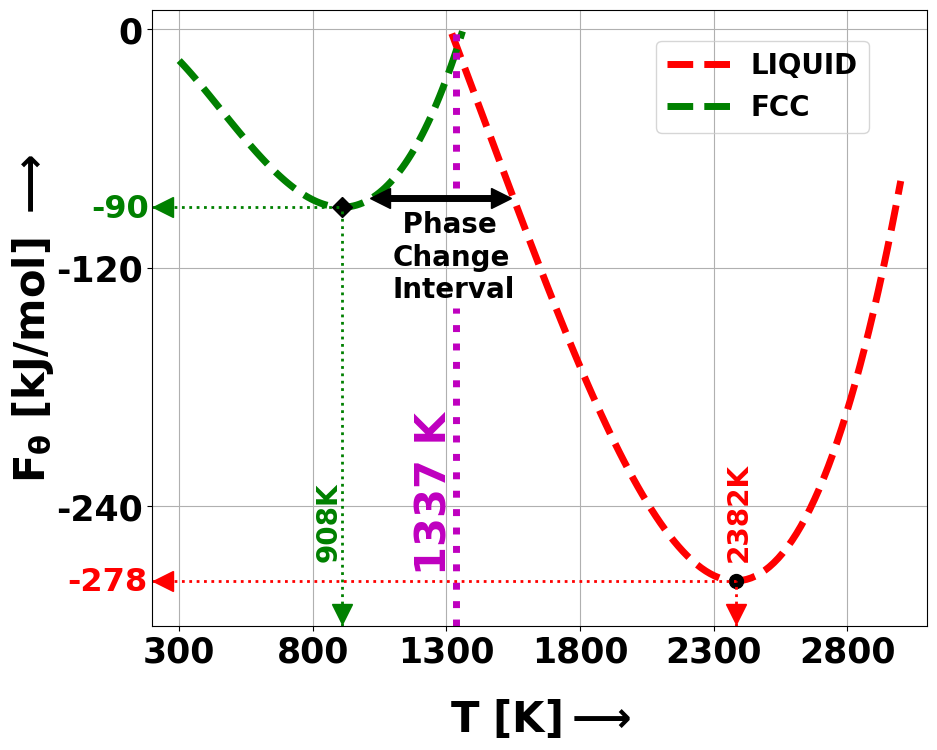

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=[10, 8], frameon=False)
ax2.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

ax2.plot(temp_LIQ_FIT, F_LIQ_FIT, c='r', lw=5, linestyle ='--', label='LIQUID')
ax2.plot(temp_FCC_FIT, F_FCC_FIT, c='g', lw=5, linestyle ='--', label='FCC')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-300_000, 10_000)
ax2.set_xlim(200, 3100)
ax2.set_xticks([300, 800, 1300, 1800, 2300, 2800], labels=[300, 800, 1300, 1800, 2300, 2800], size=25, weight='bold', color='k', rotation=0)
ax2.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=25, color='k', weight='bold')
ax2.set_ylabel(r"F$\mathbf{_\theta}$ [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=30, color='k')
ax2.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=20, size=30, color='k')
# ax2.set_title("Polynomial Fitting", fontsize=25, weight='bold')
legend2 = ax2.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=2.5,   frameon=True).get_frame().set_facecolor('none')
ax2.vlines(x=1337, ymax=0_000, ymin=-80_000, linestyle=":", color='m', lw=5)
ax2.vlines(x=1337, ymax=-140_000, ymin=-300_000, linestyle=":", color='m', lw=5)
ax2.text(x=1175 ,y=-270_000 , s='1337 K', rotation=90, fontsize=30, weight='bold', color='m')

ax2.plot(Au_LIQ_min.x, Au_LIQ_min.fun, marker = 'o', markersize=10, color='k')
ax2.plot(Au_FCC_min.x, Au_FCC_min.fun, marker = 'D', markersize=10, color='k')

ax2.vlines(x=Au_LIQ_min.x, ymax= Au_LIQ_min.fun, ymin=-300_000, linestyle=":", color='red', lw=2)
ax2.vlines(x=Au_FCC_min.x, ymax= Au_FCC_min.fun, ymin=-300_000, linestyle=":", color='green', lw=2)
ax2.hlines(y=Au_LIQ_min.fun, xmax= Au_LIQ_min.x, xmin=200, linestyle=":", color='red', lw=2)
ax2.hlines(y=Au_FCC_min.fun, xmax= Au_FCC_min.x, xmin=200, linestyle=":", color='green', lw=2)

ax2.plot(Au_LIQ_min.x, -294_000, marker='v', color='red', markersize=15)
ax2.plot(Au_FCC_min.x, -294_000, marker='v', color='green', markersize=15)
ax2.text(x=Au_FCC_min.x-100, y=-265_000 , s=f'{Au_FCC_min.x[0]:.0f}K', rotation=90, color='green', fontsize=20, weight='bold')
ax2.text(x=Au_LIQ_min.x-40, y=-265_000 , s=f'{Au_LIQ_min.x[0]:.0f}K', rotation=90, color='red', fontsize=20, weight='bold')

ax2.plot(240, Au_LIQ_min.fun, marker='<', color='red', markersize=15)
ax2.plot(240, Au_FCC_min.fun, marker='<', color='green', markersize=15)
ax2.text(x=-30, y=Au_FCC_min.fun-5000, s=f'{Au_FCC_min.fun/1000:.0f}', rotation=0, color='green', fontsize=23, weight='bold')
ax2.text(x=-120, y=Au_LIQ_min.fun-5000, s=f'{Au_LIQ_min.fun/1000:.0f}', rotation=0, color='red', fontsize=23, weight='bold')

ax2.hlines(y=-85_000, xmin=1050, xmax=1500,  linestyle="-", color='k', lw=5)
ax2.plot(1050, -85_000, marker='<', color='k', markersize=15)
ax2.plot(1505, -85_000, marker='>', color='k', markersize=15)
ax2.text(x=1100, y=-135_000, s=' Phase\nChange\nInterval', rotation=0, color='k', fontsize=20, weight='bold')

# plt.savefig('../../2_Post_Processing/figures/approx_free_energy.png',bbox_inches='tight', dpi=800)

plt.show()

## Both Figures Combined

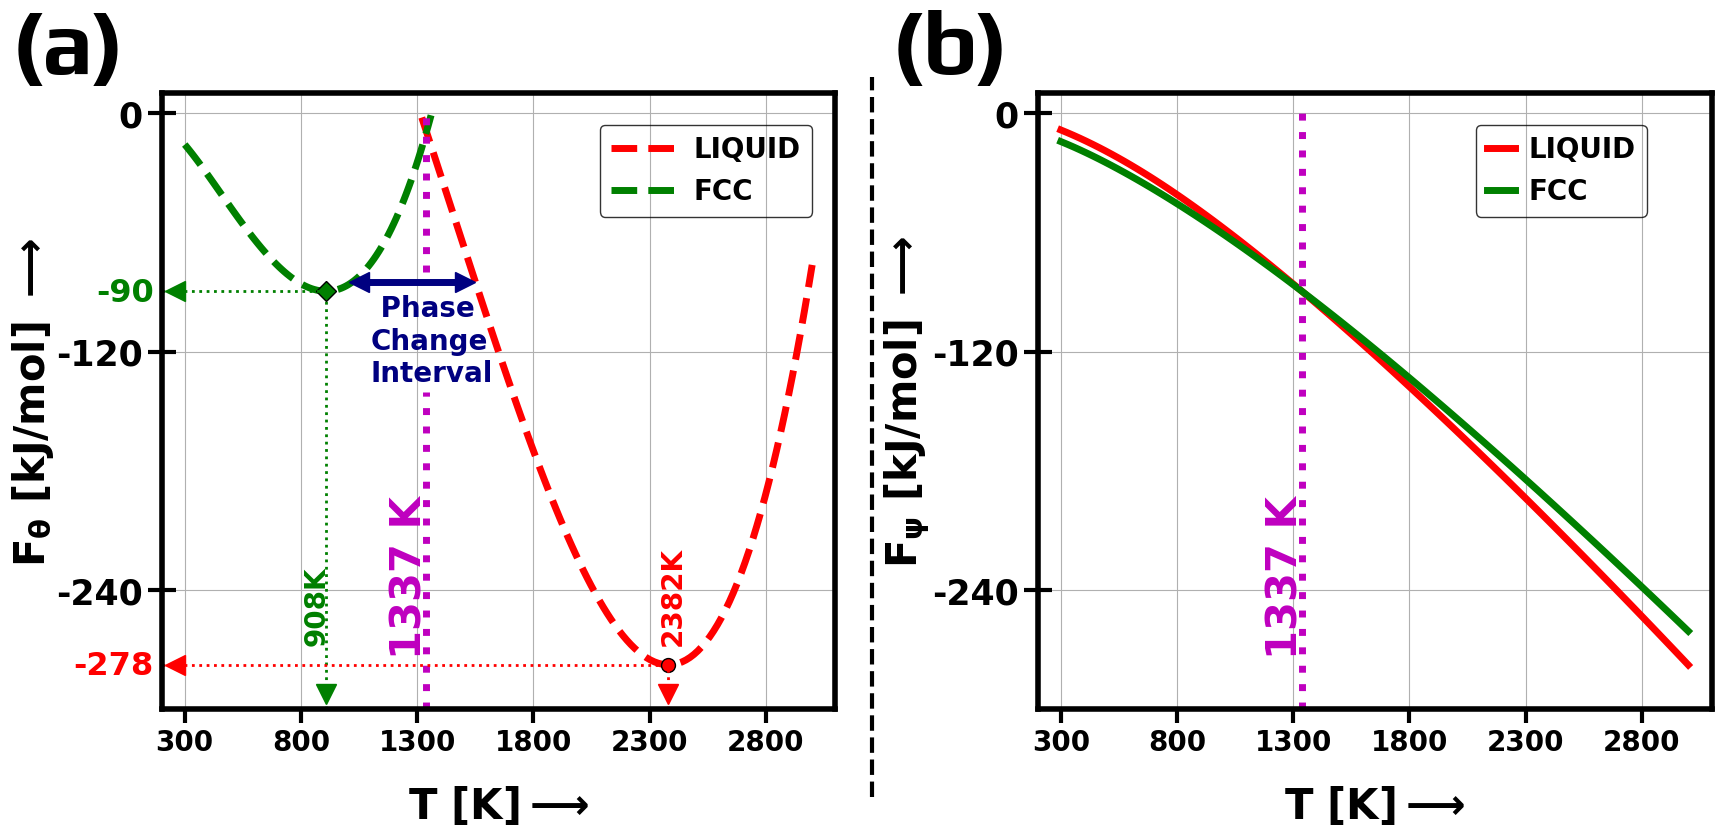

In [11]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=[20, 8], frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.1)


ax1.plot(temp_LIQ_TDB, F_LIQ_TDB, c='r', lw=5, label='LIQUID')
ax1.plot(temp_FCC_TDB, F_FCC_TDB, c='g', lw=5, label='FCC')
ax1.grid(True)
ax1.set_ylim(-300_000, 10_000)
ax1.set_xlim(200, 3100)
ax1.set_xticks([300, 800, 1300, 1800, 2300, 2800], labels=[300, 800, 1300, 1800, 2300, 2800], size=20, weight='bold', color='k', rotation=0)
ax1.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=25, color='k', weight='bold')
ax1.set_ylabel(r"F$\mathbf{_\psi}$ [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=30, color='k')
ax1.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=20, size=30, color='k')
# ax1.set_title("Expression from  TDB", fontsize=25, weight='bold')
legend1 = ax1.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=1.0, edgecolor="black", facecolor='None', frameon=True).get_frame().set_facecolor('none')
ax1.vlines(x=1337, ymax=0, ymin=-300_000, linestyle=":", color='m', lw=5)
ax1.text(x=1175 ,y=-270_000 , s='1337 K', rotation=90, fontsize=30, weight='bold', color='m')
ax1.tick_params(axis='y', which='both', direction='inout', length=20, width=3, color='k')
ax1.tick_params(axis='x', which='both', direction='out', length=10, width=3, color='k')


ax2.plot(temp_LIQ_FIT, F_LIQ_FIT, c='r', lw=5, linestyle ='--', label='LIQUID')
ax2.plot(temp_FCC_FIT, F_FCC_FIT, c='g', lw=5, linestyle ='--', label='FCC')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-300_000, 10_000)
ax2.set_xlim(200, 3100)
ax2.set_xticks([300, 800, 1300, 1800, 2300, 2800], labels=[300, 800, 1300, 1800, 2300, 2800], size=20, weight='bold', color='k', rotation=0)
ax2.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=25, color='k', weight='bold')
ax2.set_ylabel(r"F$\mathbf{_\theta}$ [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=30, color='k')
ax2.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=20, size=30, color='k')
# ax2.set_title("Polynomial Fitting", fontsize=25, weight='bold')
legend2 = ax2.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=2.5, edgecolor="black", facecolor='None', frameon=True).get_frame().set_facecolor('none')
ax2.vlines(x=1337, ymax=0_000, ymin=-80_000, linestyle=":", color='m', lw=5)
ax2.vlines(x=1337, ymax=-140_000, ymin=-300_000, linestyle=":", color='m', lw=5)
ax2.text(x=1175 ,y=-270_000 , s='1337 K', rotation=90, fontsize=30, weight='bold', color='m')

ax2.plot(Au_LIQ_min.x, Au_LIQ_min.fun, marker = 'o', markersize=10, mec='k', mfc='red',)
ax2.plot(Au_FCC_min.x, Au_FCC_min.fun, marker = 'D', markersize=10, mec='k', mfc='green',)

ax2.vlines(x=Au_LIQ_min.x, ymax= Au_LIQ_min.fun, ymin=-300_000, linestyle=":", color='red', lw=2)
ax2.vlines(x=Au_FCC_min.x, ymax= Au_FCC_min.fun, ymin=-300_000, linestyle=":", color='green', lw=2)
ax2.hlines(y=Au_LIQ_min.fun, xmax= Au_LIQ_min.x, xmin=200, linestyle=":", color='red', lw=2)
ax2.hlines(y=Au_FCC_min.fun, xmax= Au_FCC_min.x, xmin=200, linestyle=":", color='green', lw=2)

ax2.plot(Au_LIQ_min.x, -292_000, marker='v', color='red', markersize=15)
ax2.plot(Au_FCC_min.x, -292_000, marker='v', color='green', markersize=15)
ax2.text(x=Au_FCC_min.x-100, y=-265_000 , s=f'{Au_FCC_min.x[0]:.0f}K', rotation=90, color='green', fontsize=20, weight='bold')
ax2.text(x=Au_LIQ_min.x-40, y=-265_000 , s=f'{Au_LIQ_min.x[0]:.0f}K', rotation=90, color='red', fontsize=20, weight='bold')

ax2.plot(260, Au_LIQ_min.fun, marker='<', color='red', markersize=15)
ax2.plot(260, Au_FCC_min.fun, marker='<', color='green', markersize=15)
ax2.text(x=-80, y=Au_FCC_min.fun-5000, s=f'{Au_FCC_min.fun/1000:.0f}', rotation=0, color='green', fontsize=23, weight='bold')
ax2.text(x=-180, y=Au_LIQ_min.fun-5000, s=f'{Au_LIQ_min.fun/1000:.0f}', rotation=0, color='red', fontsize=23, weight='bold')

ax2.hlines(y=-85_000, xmin=1050, xmax=1500,  linestyle="-", color='navy', lw=5)
ax2.plot(1050, -85_000, marker='<', color='navy', markersize=15)
ax2.plot(1505, -85_000, marker='>', color='navy', markersize=15)
ax2.text(x=1100, y=-135_000, s=' Phase\nChange\nInterval', rotation=0, color='navy', fontsize=20, weight='bold')
ax2.tick_params(axis='y', which='both', direction='inout', length=20, width=3, color='k')
ax2.tick_params(axis='x', which='both', direction='out', length=10, width=3, color='k')

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)

line = Line2D([0.48, 0.48], [0.0, 0.90], transform=fig.transFigure, color="black", linewidth=3, linestyle='--')
fig.add_artist(line)

text_a = Text(x=0.05, y=0.905, text=r'(a)', fontsize=65, color='k', rotation=0, weight='bold', fontname='Play')
text_b = Text(x=0.49, y=0.905, text=r'(b)', fontsize=65, color='k', rotation=0, weight='bold', fontname='Play')
fig.add_artist(text_a)
fig.add_artist(text_b)

# plt.savefig('../../2_Post_Processing/figures/free_energies.png',bbox_inches='tight', dpi=800)
# plt.savefig('../../2_Post_Processing/figures/jpg/free_energies.jpg',bbox_inches='tight')
# plt.savefig('../../../0_GitHub_hostings/FreeEnergy_Benchmark_Model/2_Post_Processing/figures/free_energies.png',bbox_inches='tight', dpi=800)
# plt.savefig('../../../0_GitHub_hostings/FreeEnergy_Benchmark_Model/2_Post_Processing/figures/jpg/free_energies.jpg',bbox_inches='tight')

# plt.tight_layout()
plt.show()

# AU Database from:
#### https://www.sciencedirect.com/science/article/abs/pii/036459169190030N
#### https://sci-hub.se/10.1016/0364-5916(91)90030-N

![AU Database](AU_Data.png)

In [2]:
def Au_FCC(temp):
    if temp.any() <= 929.4:
        a,b,c,d,e,f = -6938.856, 106.830098, -22.75455, -3.85924e-3, 0.379625e-6, -25097
    elif 929.4<= temp < 1337.33:
        a,b,c,d,e,f = -93586.481, 1021.69543, -155.7067449, 87.56015e-3, 11.518716e-6, 10637210
    elif 1337.33 <= temp < 1735.8:
        a,b,c,d,e,f = 314067.829, -2016.378254, 263.2522592, -118.216828e-3, 8.923844e-6, 67999832
    else:
        a,b,c,d,e,f = -12133.783, 165.272524, -30.9616, 0, 0, 0
        
    return a + b*temp + c*temp*np.log(temp) + d*temp**2 + e*temp**3 + f/temp

def Au_LIQ(temp):
    if temp.any() <= 929.4:
        a,b,c,d,e,f = 5613.144, 97.444232, -22.75455, -3.85924e-3, 0.379625e-6, -25097
    elif 929.4<= temp < 1337.33:
        a,b,c,d,e,f = -811034.481, 1012.309564, -155.7067449, +87.56015e-3, -11.518713e-6, 10637210
    elif 1337.33 <= temp < 1735.8:
        a,b,c,d,e,f = 326619.829, -2025.76412, 263.2522592, -118.216828e-3, 8.923844e-6, -67999832
    else:
        a,b,c,d,e,f = 418.217, 155.886658, -30.9616, 0, 0, 0
        
    return a + b*temp + c*temp*np.log(temp) + d*temp**2 + e*temp**3 + f/temp


In [3]:
temp = np.linspace(300, 3100, 200)

F1 = Au_LIQ(temp)
F2 = Au_FCC(temp)
int_pts = np.argwhere(np.diff(np.sign(F1 - F2))).flatten()

Au_LIQ_min = minimize(Au_LIQ, x0=[1000], method= 'Powell', bounds=[(300, 2800)])
Au_FCC_min = minimize(Au_FCC, x0=[1000], method= 'Powell', bounds=[(300, 2800)])


Au_FCC_min.fun, Au_LIQ_min.fun

(array(-235458.34797607), array(-249186.77271269))

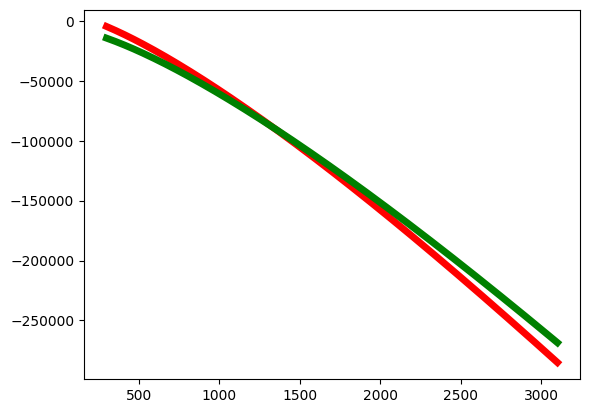

In [4]:
plt.plot(temp, F1, c='r', lw=5, label='Au$_{LIQUID}$')
plt.plot(temp, F2, c='g', lw=5, label='Au$_{SOLID}$')
plt.show()